Importação de bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from datetime import datetime

Leitura dos dados:

In [2]:
df = pd.read_excel(r"C:\Users\gabri\OneDrive\Área de Trabalho\Segmentação de Clientes Online Retail\Online Retail.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Serão realizadas transformações nos dados a fim de encontrar variaveis de comportamento dos clientes para uma análise RFM (Recencia, Frequência, Valor Monetario), com uma importante adaptação de que ao invés de utilizar o valor total gasto por um cliente, será utilizado o valor médio por transação, que proporciona uma visão mais clara sobre o comportamento de compra, independente da frequência de transações.

In [5]:
df['ValorTotal'] = df['UnitPrice'] * df['Quantity']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ValorTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [6]:
df_agrupado = df.groupby(['InvoiceNo', 'CustomerID'], as_index=False).agg({
    'ValorTotal': 'sum',
    'InvoiceDate': 'max'  # Usar a data máxima para cada transação
})
df_agrupado

,InvoiceNo,CustomerID,ValorTotal,InvoiceDate
0,536365,17850.0,139.12,2010-12-01 08:26:00
1,536366,17850.0,22.20,2010-12-01 08:28:00
2,536367,13047.0,278.73,2010-12-01 08:34:00
3,536368,13047.0,70.05,2010-12-01 08:34:00
4,536369,13047.0,17.85,2010-12-01 08:35:00
...,...,...,...,...
22185,C581484,16446.0,-168469.60,2011-12-09 09:27:00
22186,C581490,14397.0,-32.53,2011-12-09 09:57:00
22187,C581499,15498.0,-224.69,2011-12-09 10:28:00
22188,C581568,15311.0,-54.75,2011-12-09 11:57:00


In [7]:
ultima_data_df = df['InvoiceDate'].max()
rfm = df_agrupado.groupby('CustomerID').agg({
    'ValorTotal': 'mean',  # Calcular o valor médio das transações do cliente
    'InvoiceNo': 'count',  # Contar o número de transações
    'InvoiceDate': lambda x: (ultima_data_df - x.max()).days  # Calcular a recência
}).reset_index()

# Ajustar os nomes das colunas
rfm.columns = ['CustomerID', 'ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']

In [8]:
rfm

,CustomerID,ValorMonetárioMedioTransacao,Frequência,Recencia
0,12346.0,0.000000,2,325
1,12347.0,615.714286,7,1
2,12348.0,449.310000,4,74
3,12349.0,1757.550000,1,18
4,12350.0,334.400000,1,309
...,...,...,...,...
4367,18280.0,180.600000,1,277
4368,18281.0,80.820000,1,180
4369,18282.0,58.866667,3,7
4370,18283.0,130.930000,16,3


In [9]:
print(rfm.describe())

         CustomerID  ValorMonetárioMedioTransacao   Frequência     Recencia
count   4372.000000                   4372.000000  4372.000000  4372.000000
mean   15299.677722                    315.883407     5.075480    91.047118
std     1722.390705                    361.237303     9.338754   100.765435
min    12346.000000                  -4287.630000     1.000000     0.000000
25%    13812.750000                    151.991250     1.000000    16.000000
50%    15300.500000                    236.987500     3.000000    49.000000
75%    16778.250000                    370.816071     5.000000   142.000000
max    18287.000000                   6207.670000   248.000000   373.000000


Ao analisar os dados de comportamento, percebe-se outliers negativos para o valor de transação, o que não faz sentido, então essas transações serão excluidas da análise.

In [11]:
rfm = rfm[rfm['ValorMonetárioMedioTransacao'] > 0]
rfm

,CustomerID,ValorMonetárioMedioTransacao,Frequência,Recencia
1,12347.0,615.714286,7,1
2,12348.0,449.310000,4,74
3,12349.0,1757.550000,1,18
4,12350.0,334.400000,1,309
5,12352.0,140.491818,11,35
...,...,...,...,...
4367,18280.0,180.600000,1,277
4368,18281.0,80.820000,1,180
4369,18282.0,58.866667,3,7
4370,18283.0,130.930000,16,3


Em seguida, foram geradas as vizualizações dos dados de comportamento RFM:

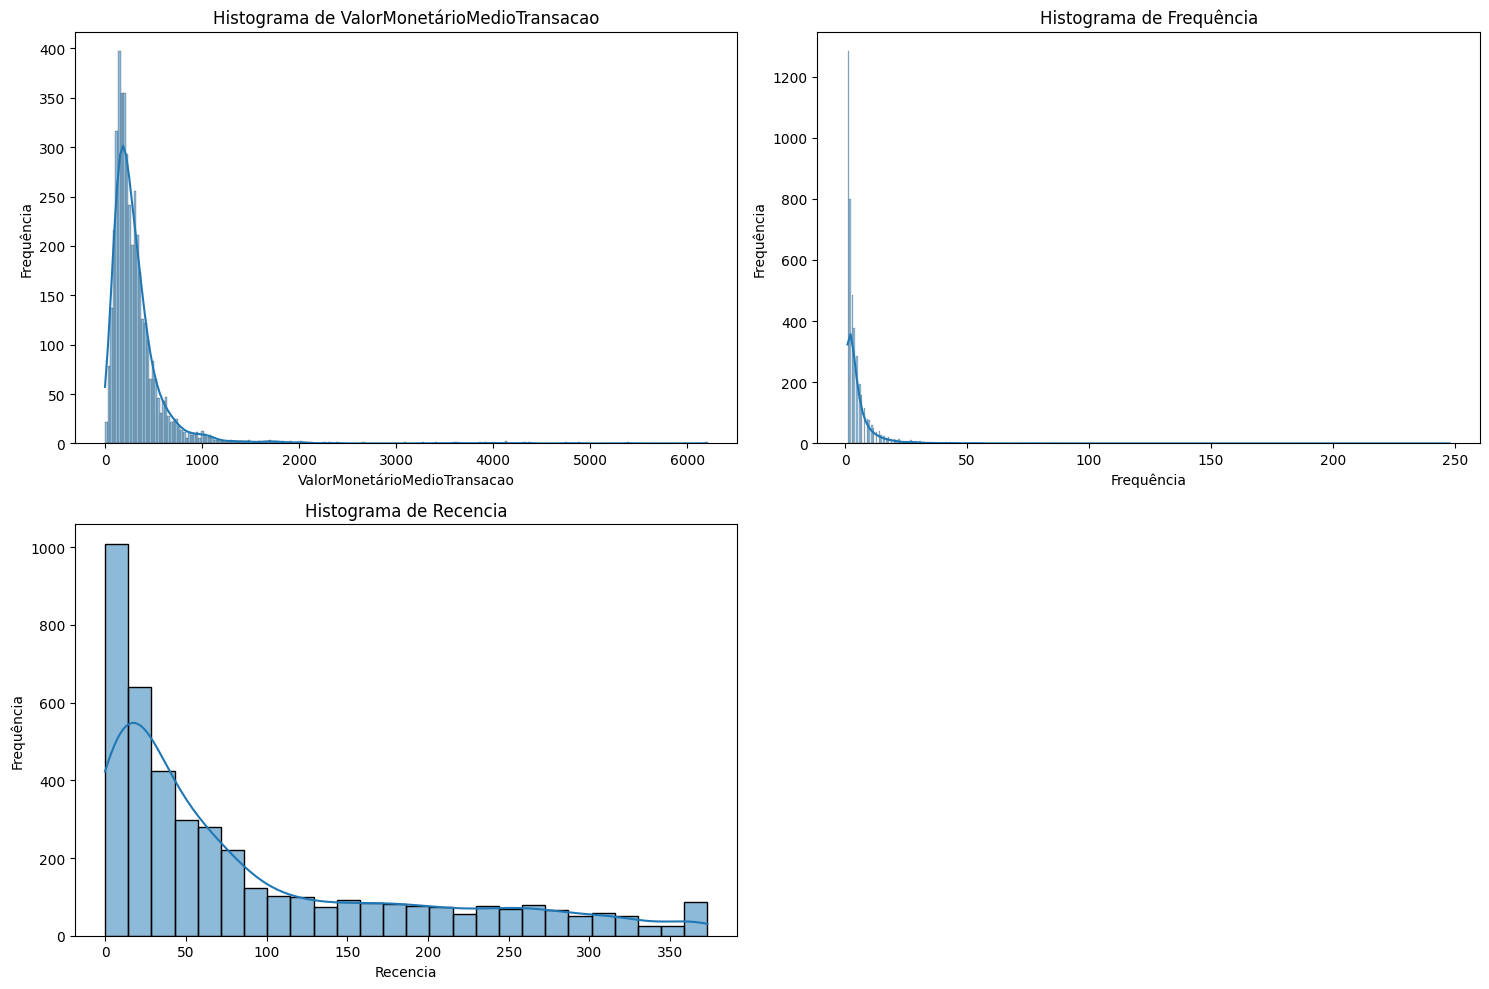

In [12]:
# Configurações gerais dos gráficos
plt.figure(figsize=(15, 10))

# Histogramas de cada variável
variables = ['ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.histplot(rfm[var], kde=True)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

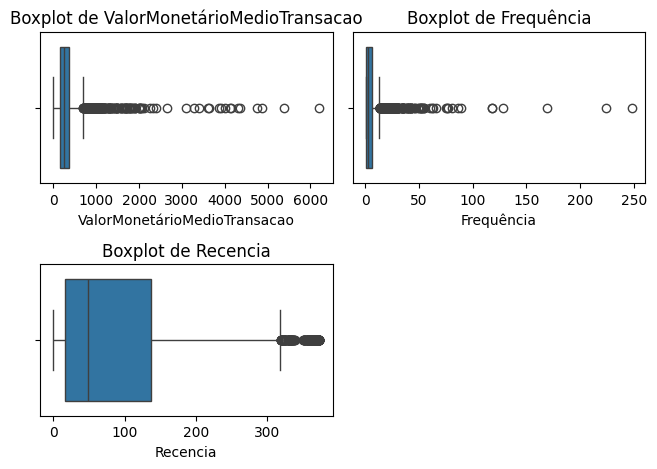

In [13]:
# Boxplots de cada variável
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=rfm[var])
    plt.title(f'Boxplot de {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

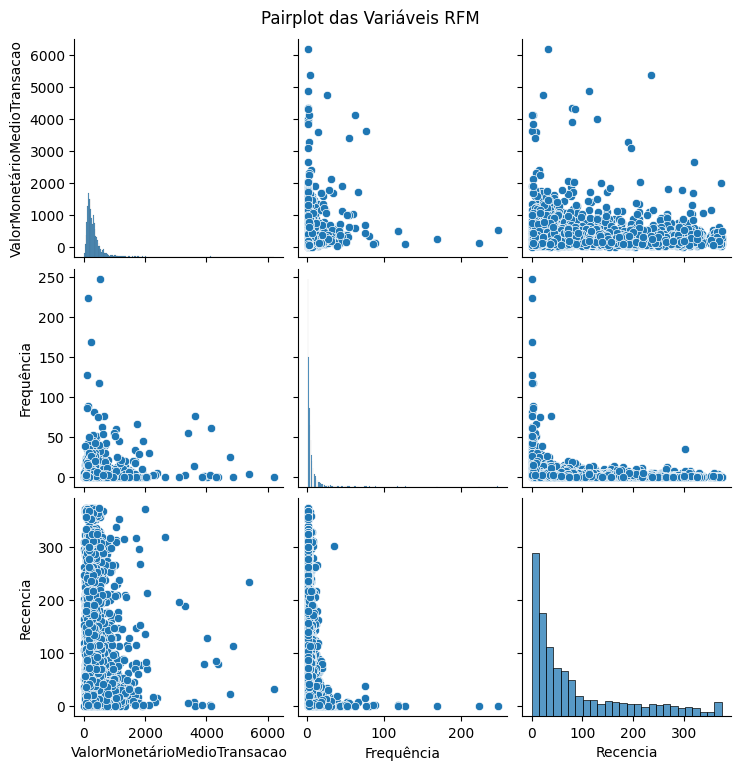

In [14]:
# Pairplot para visualizar relações entre as variáveis
sns.pairplot(rfm[['ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']])
plt.suptitle('Pairplot das Variáveis RFM', y=1.02)
plt.show()

Pode-se perceber uma boa quantidade de outliers, o que pode dificultar a formação de clusters para a segmentação dos clientes, devido a isso será utilizado o escalonamento RobustScaler, que é resistente a outliers por ser baseado nas medianas e quartis dos dados.

In [15]:
scaler = RobustScaler()
dados_transformados = scaler.fit_transform(rfm[['ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']])
dados_transformados

array([[ 1.72247553,  0.8       , -0.39669421],
       [ 0.95971773,  0.2       ,  0.20661157],
       [ 6.95637977, -0.4       , -0.25619835],
       ...,
       [-0.82998196,  0.        , -0.34710744],
       [-0.49966072,  2.6       , -0.38016529],
       [ 1.70740586,  0.        , -0.05785124]])

O proximo passo é a escolha do numero de clusters, ou seja o numero de diferentes categorias de clientes, a serem gerados, pensando na perspectiva do negócio e no número de variaveis, acredito que 6 clusters é um bom número para se ter um bom nivel de informações a respeito dos clientes. Porém serão utilizados diferentes de metodos para confirmar esse número, como silhouete score, elbow method e metodos da teoria da informação AIC/BIC:

In [16]:
range_clusters = range(2, 9)

# Lista para armazenar os silhouette scores
silhouette_scores = []

for num_clusters in range_clusters:
    # Treine o KMeans para o número de clusters especificado
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(dados_transformados)

    # Obtenha os rótulos dos clusters
    labels = kmeans.labels_

    # Calcule o silhouette score para o número atual de clusters
    silhouette_avg = silhouette_score(dados_transformados, labels)

    # Armazene o resultado
    silhouette_scores.append(silhouette_avg)

    # Exibir o resultado para cada número de clusters
    print(f"Número de clusters: {num_clusters} - Silhouette Score: {silhouette_avg}")

Número de clusters: 2 - Silhouette Score: 0.7783176726458462
Número de clusters: 3 - Silhouette Score: 0.7592306176052513
Número de clusters: 4 - Silhouette Score: 0.30957005776644114
Número de clusters: 5 - Silhouette Score: 0.37488885436580466
Número de clusters: 6 - Silhouette Score: 0.4016674097537261
Número de clusters: 7 - Silhouette Score: 0.40322545329603104
Número de clusters: 8 - Silhouette Score: 0.4021643130541477


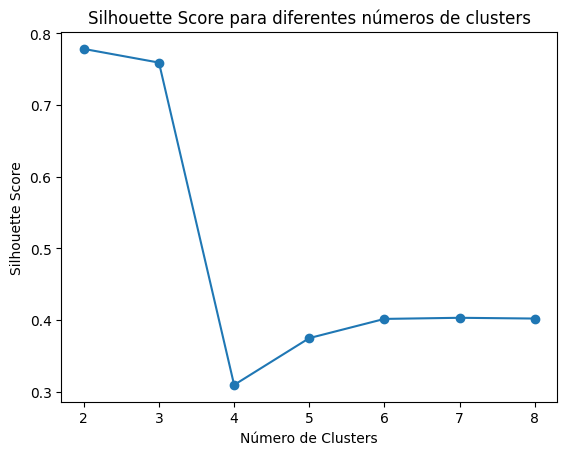

In [17]:
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score para diferentes números de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.show()

2 ou 3 clusters não trariam muita distinção entre os clientes, então excluindo essas possibilidades 6 é um bom número de clusters tendo pouco ganho ao passar disso.

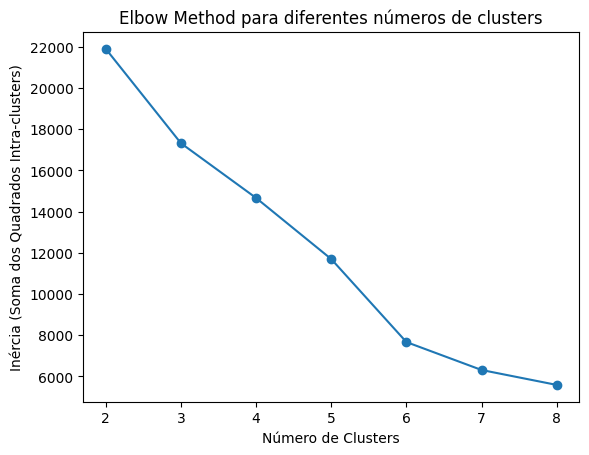

In [18]:
inertia_scores = []
range_clusters = range(2, 9)  # Números de clusters que você quer testar

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dados_transformados)  # 'X_scaled' é o seu dataset escalonado
    inertia_scores.append(kmeans.inertia_)

# Plotando o gráfico do Elbow Method
plt.plot(range_clusters, inertia_scores, marker='o')
plt.title("Elbow Method para diferentes números de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia (Soma dos Quadrados Intra-clusters)")
plt.show()

Por esse metodo também encontra-se 6 como um bom número, ganhando pouco após esse valor em relação ao nivel de complexidade que se teria para interpretar

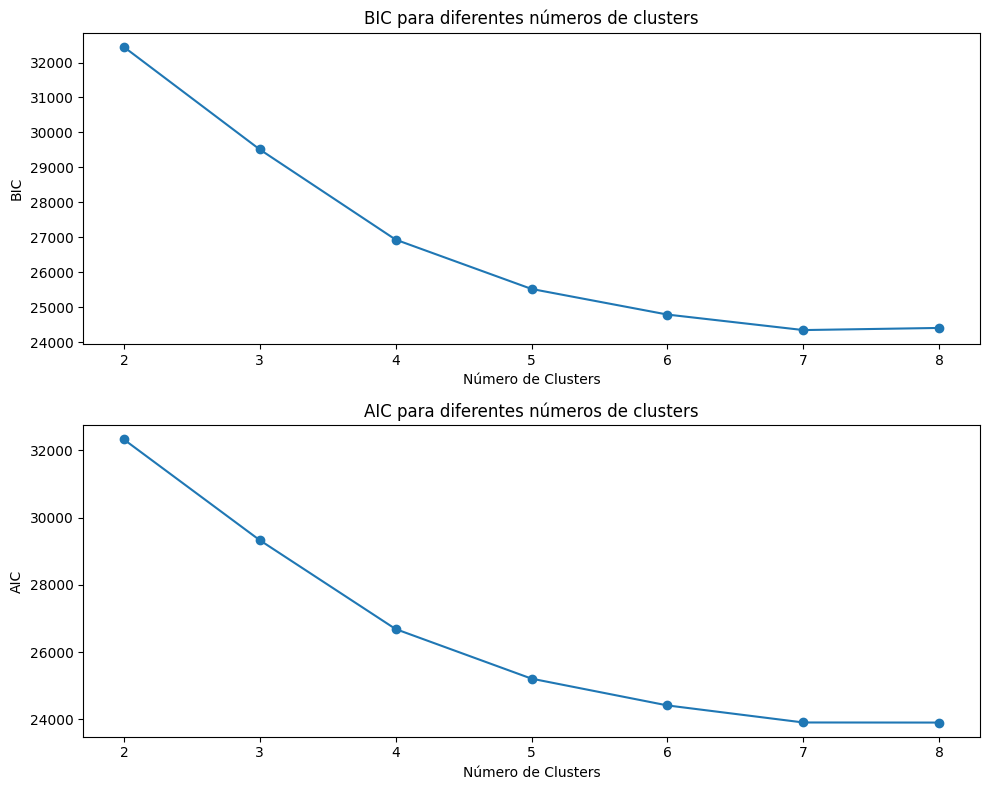

In [19]:
# Inicializar listas para armazenar os valores de BIC e AIC
bic_scores = []
aic_scores = []
range_clusters = range(2, 9)  # Número de clusters que você deseja testar

for k in range_clusters:
    # Usando GaussianMixture como uma alternativa ao KMeans para calcular BIC/AIC
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(dados_transformados)  # 'X_scaled' é o seu dataset escalonado
    
    # Armazenar os valores de BIC e AIC
    bic_scores.append(gmm.bic(dados_transformados))
    aic_scores.append(gmm.aic(dados_transformados))

# Plotar os gráficos para BIC e AIC
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico para BIC
ax[0].plot(range_clusters, bic_scores, marker='o')
ax[0].set_title("BIC para diferentes números de clusters")
ax[0].set_xlabel("Número de Clusters")
ax[0].set_ylabel("BIC")

# Gráfico para AIC
ax[1].plot(range_clusters, aic_scores, marker='o')
ax[1].set_title("AIC para diferentes números de clusters")
ax[1].set_xlabel("Número de Clusters")
ax[1].set_ylabel("AIC")

plt.tight_layout()
plt.show()

através dos metodos da teoria da informação que levam em conta a interpretabilidade do problema, também pode-se observa que 6 é um bom número de clusters, com isso fica definido essse número.

Serão gerados agrupamentos utilizando duas abordagens diferentes:

• K-Means

•Gaussian Mixture Model (GMM)

Após isso será analisado  qual dos dois algoritmos trazem uma melhor qualidade de clusters através da distribuição de clusters e das suas caracteristicas.

In [20]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_clusters = kmeans.fit_predict(dados_transformados)

# Adicionar os clusters do kmeans ao DataFrame original
rfm_com_kmeans_clusters = rfm.copy()
rfm_com_kmeans_clusters['KMeans_Cluster'] = kmeans_clusters

gmm = GaussianMixture(n_components=6, random_state=42)
gmm_clusters = gmm.fit_predict(dados_transformados)

# Adicionar os clusters do GMM ao DataFrame original
rfm_com_gmm_clusters = rfm.copy()
rfm_com_gmm_clusters['GMM_Cluster'] = gmm_clusters

In [21]:
# Distribuição de clusters no KMeans
kmeans_cluster_distribution = rfm_com_kmeans_clusters['KMeans_Cluster'].value_counts()
print("Distribuição de Clusters - KMeans:")
print(kmeans_cluster_distribution)

# Distribuição de clusters no GMM
gmm_cluster_distribution = rfm_com_gmm_clusters['GMM_Cluster'].value_counts()
print("Distribuição de Clusters - GMM:")
print(gmm_cluster_distribution)

Distribuição de Clusters - KMeans:
KMeans_Cluster
0    2726
3    1019
4     356
1     195
2      17
5       6
Name: count, dtype: int64
Distribuição de Clusters - GMM:
GMM_Cluster
0    1602
3    1219
1     655
4     652
2     105
5      86
Name: count, dtype: int64


C:\Users\gabri\AppData\Local\Temp\ipykernel_25744\2055232894.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_com_kmeans_clusters, x='KMeans_Cluster', y='ValorMonetárioMedioTransacao', palette='Set1')
C:\Users\gabri\AppData\Local\Temp\ipykernel_25744\2055232894.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_com_kmeans_clusters, x='KMeans_Cluster', y='Frequência', palette='Set1')
C:\Users\gabri\AppData\Local\Temp\ipykernel_25744\2055232894.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_com_kmeans_clus

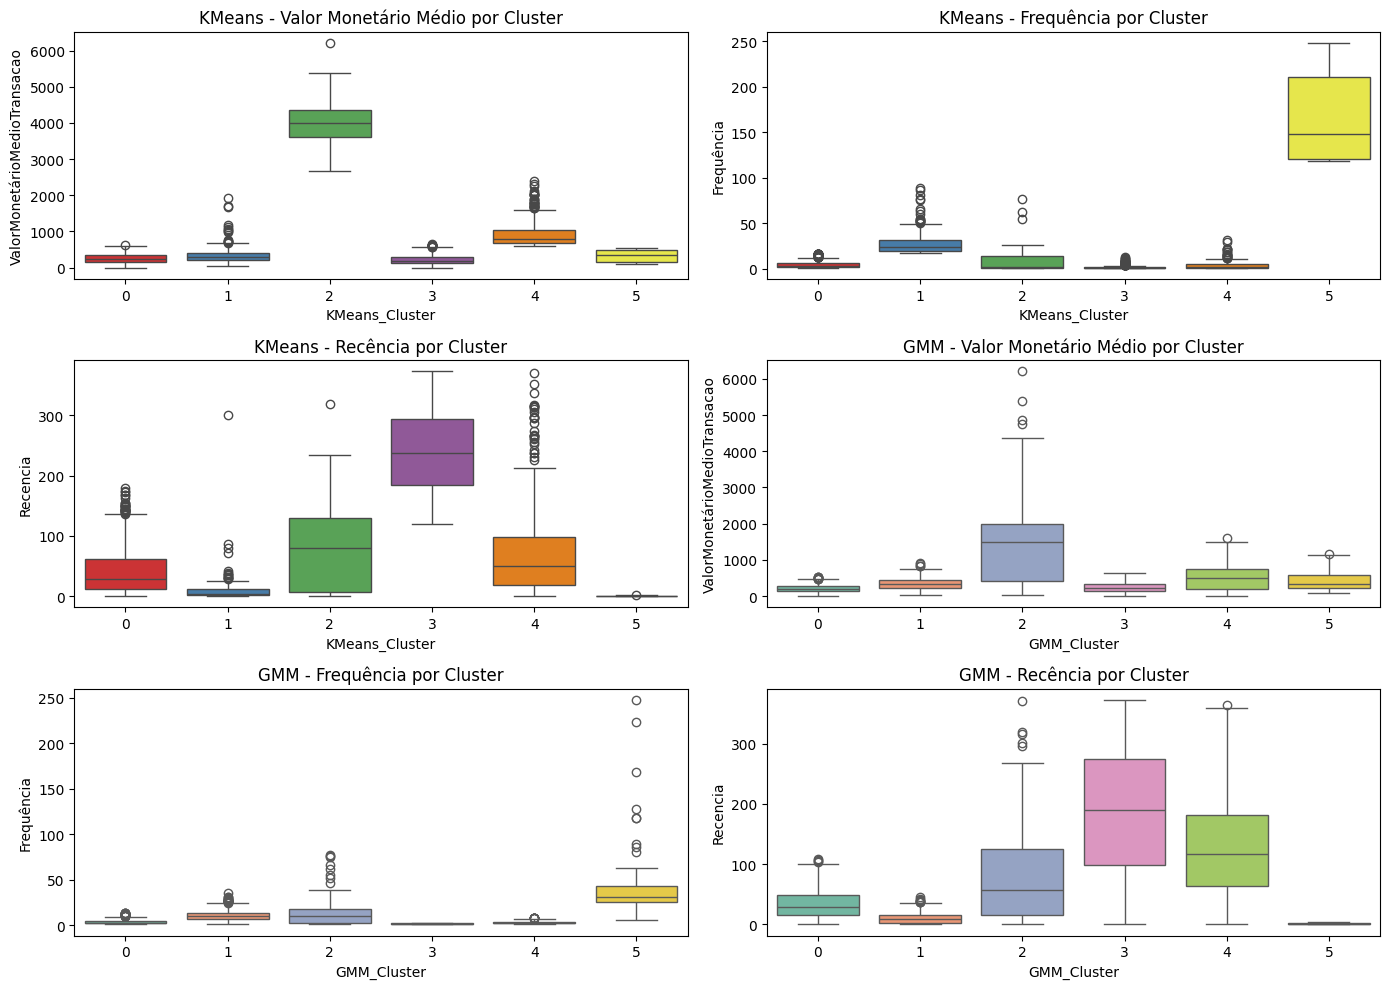

In [22]:
# Configurar o gráfico
plt.figure(figsize=(14, 10))

# Boxplots para KMeans
plt.subplot(3, 2, 1)
sns.boxplot(data=rfm_com_kmeans_clusters, x='KMeans_Cluster', y='ValorMonetárioMedioTransacao', palette='Set1')
plt.title('KMeans - Valor Monetário Médio por Cluster')

plt.subplot(3, 2, 2)
sns.boxplot(data=rfm_com_kmeans_clusters, x='KMeans_Cluster', y='Frequência', palette='Set1')
plt.title('KMeans - Frequência por Cluster')

plt.subplot(3, 2, 3)
sns.boxplot(data=rfm_com_kmeans_clusters, x='KMeans_Cluster', y='Recencia', palette='Set1')
plt.title('KMeans - Recência por Cluster')

# Boxplots para GMM
plt.subplot(3, 2, 4)
sns.boxplot(data=rfm_com_gmm_clusters, x='GMM_Cluster', y='ValorMonetárioMedioTransacao', palette='Set2')
plt.title('GMM - Valor Monetário Médio por Cluster')

plt.subplot(3, 2, 5)
sns.boxplot(data=rfm_com_gmm_clusters, x='GMM_Cluster', y='Frequência', palette='Set2')
plt.title('GMM - Frequência por Cluster')

plt.subplot(3, 2, 6)
sns.boxplot(data=rfm_com_gmm_clusters, x='GMM_Cluster', y='Recencia', palette='Set2')
plt.title('GMM - Recência por Cluster')

plt.tight_layout()
plt.show()

In [23]:
rfm_com_kmeans_clusters.groupby('KMeans_Cluster')[['ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']].describe()

ValorMonetárioMedioTransacao                           \
                                      count         mean         std   
KMeans_Cluster                                                         
0                                    2726.0   255.679836  125.776666   
1                                     195.0   355.688470  267.152664   
2                                      17.0  4096.558619  867.079462   
3                                    1019.0   217.462265  132.918349   
4                                     356.0   934.757442  363.527255   
5                                       6.0   330.740869  200.847025   

                                                                     \
                         min          25%          50%          75%   
KMeans_Cluster                                                        
0               2.273737e-13   158.032500   231.936000   338.656250   
1               3.324205e+01   203.041893   289.375833   397.579052   
2               2.661240e+03  3601.106429  4008.620000  4366.780000   
3               2.842171e-14   115.725000   182.645000   302.640000   
4               5.922900e+02   673.316250   798.536250  1043.535000   
5               9.151445e+01   157.015331   362.511929   499.245551   

                            Frequência              ...                 \
                        max      count        mean  ...     75%    max   
KMeans_Cluster                                      ...                  
0                613.830909     2726.0    4.475422  ...    6.00   16.0   
1               1915.769130      195.0   28.261538  ...   31.00   89.0   
2               6207.670000       17.0   14.941176  ...   14.00   77.0   
3                660.000000     1019.0    1.768400  ...    2.00   13.0   
4               2398.192000      356.0    3.741573  ...    5.00   31.0   
5                534.567016        6.0  167.500000  ...  210.25  248.0   

               Recencia                                                      \
                  count        mean        std    min    25%    50%     75%   
KMeans_Cluster                                                                
0                2726.0   39.917828  34.781950    0.0   11.0   29.0   61.00   
1                 195.0   10.082051  24.425216    0.0    1.0    3.0   11.00   
2                  17.0   88.294118  96.586596    0.0    7.0   79.0  129.00   
3                1019.0  242.091266  68.698614  119.0  184.0  238.0  294.00   
4                 356.0   76.098315  80.750870    0.0   18.0   50.0   97.50   
5                   6.0    0.500000   0.836660    0.0    0.0    0.0    0.75   

                       
                  max  
KMeans_Cluster         
0               179.0  
1               301.0  
2               319.0  
3               373.0  
4               371.0  
5                 2.0  

[6 rows x 24 columns]

Características dos clusters K-Means:

Cluster 5: 6 clientes com compras baixas-medias com altissima freq  media de 167 vezes no ano (VIP1)

Cluster 2: 17 clientes com compras aaltissimas com boa frequencia porém alguns tem tempo sem comprar, clientes para tomar medidas de retenção (VIP2)

Cluster 1: 195 clientes com valor medio de compra, frequencia alta ~2/mes, clientes ativos com baixa recencia

Cluster 4: 356  clientes com valores de compras altas e frequencia baixa e em media com tempo sem comprar, possiveis clientes (VIP2)

Cluster 3: 1019  clientes que compraram valores baixos 1 ou poucas vezes e não voltaram

Cluster 0:  2726 clientes que compraram pouco com pouca frequencia e em media tem tempo razoavelmente alto sem comprar


In [24]:
rfm_com_gmm_clusters.groupby('GMM_Cluster')[['ValorMonetárioMedioTransacao', 'Frequência', 'Recencia']].describe()

ValorMonetárioMedioTransacao                            \
                                   count         mean          std   
GMM_Cluster                                                          
0                                 1602.0   211.762957    93.381508   
1                                  655.0   338.945591   153.711035   
2                                  105.0  1583.716685  1334.343376   
3                                 1219.0   242.142002   131.553727   
4                                  652.0   510.001537   333.708221   
5                                   86.0   431.397089   276.334128   

                                                                              \
                      min         25%          50%          75%          max   
GMM_Cluster                                                                    
0            2.273737e-13  144.130500   197.655714   274.120625   535.360000   
1            2.389625e+01  215.106833   321.992727   442.792500   901.935556   
2            3.324205e+01  404.612143  1488.920000  2002.400000  6207.670000   
3            2.842171e-14  135.825000   217.200000   337.000000   623.750000   
4            3.750000e+00  199.972917   507.417917   737.119500  1596.270000   
5            8.022333e+01  219.234783   345.184731   594.419013  1171.461111   

            Frequência             ...              Recencia              \
                 count       mean  ...   75%    max    count        mean   
GMM_Cluster                        ...                                     
0               1602.0   3.775905  ...   5.0   13.0   1602.0   32.157303   
1                655.0  10.949618  ...  14.0   35.0    655.0   10.748092   
2                105.0  14.800000  ...  18.0   77.0    105.0   84.095238   
3               1219.0   1.282199  ...   2.0    2.0   1219.0  192.448728   
4                652.0   3.173313  ...   4.0    8.0    652.0  128.792945   
5                 86.0  42.988372  ...  43.0  248.0     86.0    1.325581   

                                                          
                    std  min   25%    50%     75%    max  
GMM_Cluster                                               
0             22.767822  0.0  15.0   28.0   49.00  108.0  
1              8.903444  0.0   3.0    9.0   16.00   45.0  
2             87.551910  0.0  15.0   57.0  125.00  371.0  
3            101.158404  0.0  98.0  190.0  274.00  373.0  
4             82.023142  0.0  63.0  116.0  182.25  365.0  
5              1.231373  0.0   0.0    1.0    2.00    4.0  

[6 rows x 24 columns]

Características dos clusters gmm:

Cluster 5: 86 clientes com media de transação 430(medio) , ALTA frequencia de 42/ano e baixa recencia (VIP 1)

Cluster 2: 105 clientes com  media transação 1583(altissima)  boa frequencia de 14/ANO (VIP2) (alguns com 2 meses ou mais sem comprar)

Cluster 4: 652 clientes com media de transação 510 (alto) frequencia baixa media de 3 compras e não voltaram mais, possiveis clientes (VIP2)

Cluster 1: 655 clientes com media de transação 338 (baixo-medio) frequencia media de 11 vezes no ano e baixa recencia (cliente medio ativo)

Cluster 3: 1219 clientes com media de transação 242(baixo) compraram 1 ou 2 vezes e não voltaram

Cluster 0: 1602 clientes com media de transação 211(baixo) frequencia baixae recencia media 30 dias

Percebe-se que o GMM trouxe uma qualidade muito melhor de clusters, tendo separado um maior número tanto de clientes VIP, quanto de clientes de alto valor que podem ser atraidos de volta.

Vizualização em 3D dos Clusters Finais:

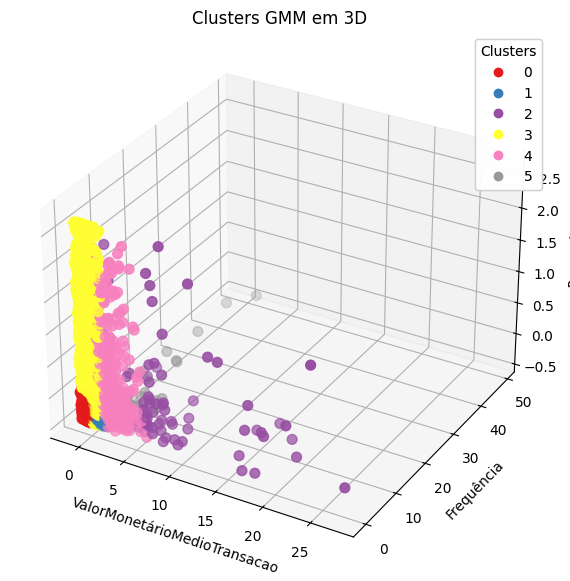

In [25]:
# Configuração do gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Dados escalonados já com os clusters (GMM)
x = dados_transformados[:, 0]  # 'ValorMonetárioMedioTransacao'
y = dados_transformados[:, 1]  # 'Frequência'
z = dados_transformados[:, 2]  # 'Recencia'

# Plotar os clusters
scatter = ax.scatter(x, y, z, c=gmm_clusters, cmap='Set1', s=50)

# Configuração dos eixos
ax.set_xlabel('ValorMonetárioMedioTransacao')
ax.set_ylabel('Frequência')
ax.set_zlabel('Recencia')
plt.title("Clusters GMM em 3D")

# Adicionar uma legenda com as cores dos clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

A análise dos grupos revelou 2 perfis de clientes VIPs, clientes inativos de alto ticket médio, clientes medios e consumidores de baixa frequência, permitindo a implementação de estratégias direcionadas de retenção, como:

- Programas de fidelidade exclusivos para VIPs
- Campanhas de reativação para clientes inativos
- Ofertas personalizadas para aumentar o ticket médio dos clientes recorrentes

Esse tipo de segmentação ajuda a entender melhor o comportamento dos clientes e a definir ações estratégicas de marketing.